In [52]:
import pickle
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

# cust_functions folder
from cust_functions.training import *
from cust_functions.graph_networks import *
from cust_functions.graph_creation import *

# Set random seed
SEED = 42
set_seed(SEED)

In [68]:
import numpy as np
import pandas as pd

def nonlinear_transform(expression):
    """
    Apply a nonlinear transformation to gene expression data.
    :param expression: Gene expression value.
    :return: Transformed value.
    """
    return np.log1p(np.abs(expression)) * np.exp(-expression**2) * np.sin(expression) + np.cos(expression) + np.random.normal(0, 0.1)

def simulate_disease_status(gene_expression, pathways, key_pathways, key_genes):
    """
    Simulate disease status based on gene expression, pathways, and key genes.
    :param gene_expression: Noisy gene expression data.
    :param pathways: Dictionary of pathways and their associated genes.
    :param key_pathways: Set of pathways particularly relevant to the disease.
    :param key_genes: List of genes particularly relevant to the disease.
    :return: List of simulated disease statuses for each patient.
    """
    disease_status = []
    for patient in gene_expression:
        status = 0
        for pathway, genes in pathways.items():
            if 'Noise' not in pathway:
                mean_expression = nonlinear_transform(np.mean(patient[genes]))
                print(mean_expression)
                pathway_influence = 4 if pathway in key_pathways else 0
                status += pathway_influence if mean_expression > 1 else 0
        key_gene_expression = nonlinear_transform(np.mean(patient[key_genes])) + 3
        key_gene_influence =  key_gene_expression if key_gene_expression > 3 else 0
        disease_threshold = 3
        status += key_gene_influence
        disease_status.append(1 if status > disease_threshold else 0)
    return disease_status

def create_synthetic_data():
    """
    Create a synthetic dataset mimicking gene expression data in a biological study.
    :return: qm_matrix_synthetic, design_matrix_synthetic, translations_synthetic, parent_child_df, key_genes, key_pathways
    """
    # Parameters for simulation
    num_patients = 1000
    num_genes = 500
    num_key_genes = 50
    num_pathways_per_level = [100, 30, 5]
    num_key_pathways = 10

    # Simulate gene expression data
    gene_expression = np.random.rand(num_patients, num_genes)
    gene_expression_noise = np.random.normal(0, 2, gene_expression.shape)
    gene_expression_noisy = gene_expression + gene_expression_noise

    # Introduce correlated noise
    correlated_genes_indices = np.random.choice(num_genes, 450, replace=False)
    correlated_noise = np.random.normal(0, 3, (num_patients, 1))
    gene_expression_noisy[:, correlated_genes_indices] += correlated_noise

    # Select key genes
    key_genes = np.random.choice(num_genes, num_key_genes, replace=False)

    # Generate pathways and their relationships
    pathways = {}
    key_pathways = set()
    parent_child_pairs = []

    previous_level_pathways = []
    for level in range(4):
        current_level_pathways = []
        for i in range(num_pathways_per_level[level]):
            pathway_name = f'Level_{level}Pathway{i}'
            current_level_pathways.append(pathway_name)
            pathway_genes = []

            if level == 0:
                # Level 0 pathway generation
                if i < num_key_pathways:
                    num_key_genes_in_pathway = np.random.randint(1, min(num_key_genes, 3))
                    key_genes_for_pathway = np.random.choice(key_genes, size=num_key_genes_in_pathway, replace=False)
                    pathway_genes.extend(key_genes_for_pathway)

                def create_probability_distribution(size):
                    # inverse of exponential function
                    probabilities = np.array([1 / (i + 1) for i in range(size)])
                    normalized_probabilities = probabilities / probabilities.sum()  # Normalize to sum up to 1
                    return normalized_probabilities

                # Create a probability distribution for your choice
                prob_distribution = create_probability_distribution(num_genes - len(key_genes))

                # Choosing additional genes with custom probability distribution
                additional_genes = np.random.choice([gene for gene in range(num_genes) if gene not in key_genes],
                                                    size=np.random.randint(1, 10), p=prob_distribution, replace=False)
                
                pathway_genes.extend(additional_genes)
            else:
                # assign each parent one child
                for parent_pathway in previous_level_pathways:
                    parent_genes = pathways[parent_pathway]
                    # add all parent genes to child
                    pathway_genes.extend(parent_genes)
                    parent_child_pairs.append((parent_pathway, pathway_name))
                
                """
                num_parents = np.random.randint(3, 6)
                chosen_parents = np.random.choice(previous_level_pathways, size=num_parents, replace=False)
                for parent_pathway in chosen_parents:
                    parent_genes = pathways[parent_pathway]
                    num_genes_to_choose = min(len(parent_genes), np.random.randint(3, 10))
                    pathway_genes.extend(np.random.choice(parent_genes, size=num_genes_to_choose, replace=False))
                    parent_child_pairs.append((parent_pathway, pathway_name))
                """

            pathways[pathway_name] = np.array(pathway_genes, dtype=int)
            if i < num_key_pathways:
                key_pathways.add(pathway_name)

        previous_level_pathways = current_level_pathways

    parent_child_df = pd.DataFrame(parent_child_pairs, columns=['parent', 'child'])

    """
    # Generate noise pathways
    num_noise_pathways = 100
    for i in range(num_noise_pathways):
        pathways[f'Noise_Pathway_{i}'] = np.random.choice(num_genes, size=np.random.randint(5, 15), replace=False)
    """
    # Generate disease status
    disease_status = simulate_disease_status(gene_expression_noisy, pathways, key_pathways, key_genes)

    # Process data for output
    disease_status = [status for status in disease_status]
    df = pd.DataFrame(gene_expression_noisy, columns=[f'Gene_{i}' for i in range(num_genes)])
    df['group'] = disease_status
    qm_matrix_synthetic = df.iloc[:, :-1].T
    qm_matrix_synthetic.reset_index(inplace=True)
    qm_matrix_synthetic.rename(columns={'index': 'Genes'}, inplace=True)
    qm_matrix_synthetic.columns = ['Protein'] + [f'Patient{i-1}' for i in range(1, len(qm_matrix_synthetic.columns))]

    design_matrix_synthetic = df.iloc[:, [-1]].reset_index()
    design_matrix_synthetic.rename(columns={'index': 'sample'}, inplace=True)
    design_matrix_synthetic['sample'] = design_matrix_synthetic['sample'].apply(lambda x: f'Patient{x}')

    translations_synthetic = pd.DataFrame([(number, pathway) for pathway, numbers in pathways.items() for number in numbers], 
                                          columns=['input', 'translation'])
    translations_synthetic["input"] = translations_synthetic["input"].apply(lambda x: f'Gene_{x}')

    return qm_matrix_synthetic, design_matrix_synthetic, translations_synthetic, parent_child_df, key_genes, key_pathways, pathways


In [69]:
qm_matrix_synthetic, design_matrix_synthetic, translations_synthetic, parent_child_df, key_genes, key_pathways, pathways = create_synthetic_data()

IndexError: list index out of range

In [64]:
translations_synthetic

,input,translation
0,Gene_190,Level_0Pathway0
1,Gene_31,Level_0Pathway0
2,Gene_38,Level_0Pathway1
3,Gene_4,Level_0Pathway1
4,Gene_2,Level_0Pathway1
...,...,...
1907197,Gene_4,Level_3Pathway4
1907198,Gene_96,Level_3Pathway4
1907199,Gene_1,Level_3Pathway4
1907200,Gene_237,Level_3Pathway4


In [14]:
len(pathways)

230

In [15]:
len(np.unique(parent_child_df))

230

# ML models

In [10]:
# perform train test split on data by splitting sample column of y
train_size = 0.9
patients = design_matrix_synthetic['sample']
train_patients = random.sample(list(patients), int(train_size*len(patients)))
test_patients = [p for p in patients if p not in train_patients]

# select 'Protein' column and columns corresponding to train and test patients
X_train = qm_matrix_synthetic.loc[:, qm_matrix_synthetic.columns.str.contains("Protein") | qm_matrix_synthetic.columns.isin(train_patients)]
X_test = qm_matrix_synthetic.loc[:, qm_matrix_synthetic.columns.str.contains("Protein") | qm_matrix_synthetic.columns.isin(test_patients)]
y_train = design_matrix_synthetic[design_matrix_synthetic['sample'].isin(train_patients)]
y_test = design_matrix_synthetic[design_matrix_synthetic['sample'].isin(test_patients)]

# Reshape data
X_train_ml = X_train.drop(['Protein'], axis=1).transpose()
X_test_ml = X_test.drop(['Protein'], axis=1).transpose()
y_train_ml = y_train['group']
y_test_ml = y_test['group']

In [197]:
models = [DummyClassifier(random_state = SEED),
          SVC(random_state = SEED, probability = True),
          LogisticRegression(random_state = SEED, max_iter = 10000),
          KNeighborsClassifier(),
          RandomForestClassifier(random_state = SEED),
          AdaBoostClassifier(random_state = SEED),]

grid = {"Dummy": {"strategy": ["most_frequent"]},
        "SVC": {"C": [0.1, 1, 2], "kernel": ["linear", "rbf", "poly"]},
        "LR": {"C": [0.00001, 0.01, 0.1, 1], "penalty": ["l1", "l2", "elasticnet"]},
        "KNN": {"n_neighbors": [5, 10, 15, 20], "weights": ["uniform", "distance"]},
        "RF": {"n_estimators": [50, 100, 150]},
        "AdaBoost": {"n_estimators": [50, 100, 150]}}

scoring = {
    'roc_auc': 'roc_auc',
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'f1_macro': make_scorer(f1_score, average='macro'),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score)
}

best_models, best_params, fitted_models = gridsearch(models, grid, X_train_ml, y_train_ml, scoring, refit = 'roc_auc')


Training model Dummy
Best parameters for Dummy: {'strategy': 'most_frequent'}
Best ROC AUC score for Dummy: 0.5
Training model SVC
Best parameters for SVC: {'C': 2, 'kernel': 'rbf'}
Best ROC AUC score for SVC: 0.9304395604395606
Training model LR
Best parameters for LR: {'C': 1e-05, 'penalty': 'l2'}
Best ROC AUC score for LR: 0.5926923076923077
Training model KNN


/scratch/yves/miniconda/envs/pytorch_cuda/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
40 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/scratch/yves/miniconda/envs/pytorch_cuda/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/scratch/yves/miniconda/envs/pytorch_cuda/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/scratch/yves/miniconda/envs/pytorch_cuda/lib/python3.8/site-packages/sklearn/li

Best parameters for KNN: {'n_neighbors': 5, 'weights': 'distance'}
Best ROC AUC score for KNN: 0.9463186813186812
Training model RF
Best parameters for RF: {'n_estimators': 100}
Best ROC AUC score for RF: 0.739368131868132
Training model AdaBoost
Best parameters for AdaBoost: {'n_estimators': 100}
Best ROC AUC score for AdaBoost: 0.6396153846153846


In [198]:
for metric in best_models:
    best_models[metric].sort_values("Best Score", ascending=False, inplace=True)
    print(f"\nBest models based on {metric}:\n{best_models[metric]}")


Best models based on roc_auc:
      Model  Best Score                                Best Params
3       KNN    0.946319  {'n_neighbors': 5, 'weights': 'distance'}
1       SVC    0.930440                  {'C': 2, 'kernel': 'rbf'}
4        RF    0.739368                      {'n_estimators': 100}
5  AdaBoost    0.639615                      {'n_estimators': 100}
2        LR    0.592692              {'C': 1e-05, 'penalty': 'l2'}
0     Dummy    0.500000              {'strategy': 'most_frequent'}

Best models based on accuracy:
      Model  Best Score                                Best Params
3       KNN    0.844444  {'n_neighbors': 5, 'weights': 'distance'}
1       SVC    0.822222                  {'C': 2, 'kernel': 'rbf'}
0     Dummy    0.755556              {'strategy': 'most_frequent'}
2        LR    0.755556              {'C': 1e-05, 'penalty': 'l2'}
5  AdaBoost    0.733333                      {'n_estimators': 100}
4        RF    0.677778                      {'n_estimators': 100}

# GNN

Number of nodes:  196
Number of edges:  157
Number of nodes with no edges:  0
Mean number of edges per node:  1.6
Max number of edges per node:  4
Min number of edges per node:  1
Median number of edges per node:  1.0
Number of nodes without proteins:  0


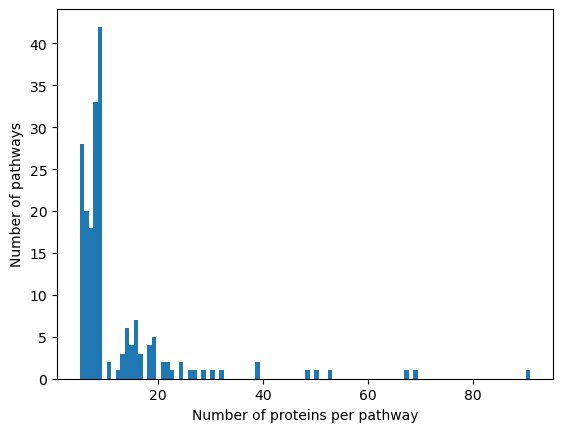

In [23]:
G = create_pathway_graph(parent_child_df, translations_synthetic, descendants=True)

print("Number of nodes: ", len(G.nodes))
print("Number of edges: ", len(G.edges))
print("Number of nodes with no edges: ", len([n for n in G.nodes if G.degree(n)==0]))
print("Mean number of edges per node: ", np.round(np.mean([G.degree(n) for n in G.nodes]),1))
print("Max number of edges per node: ", np.max([G.degree(n) for n in G.nodes]))
print("Min number of edges per node: ", np.min([G.degree(n) for n in G.nodes]))
print("Median number of edges per node: ", np.median([G.degree(n) for n in G.nodes]))
print("Number of nodes without proteins: ", len([n for n in G.nodes if len(G.nodes[n].get('proteins', '') )==0]))


num_proteins_per_pathway = [len(G.nodes[node].get('proteins', '')) for node in G.nodes()]
plt.hist(num_proteins_per_pathway, bins=100)
plt.xlabel("Number of proteins per pathway")
plt.ylabel("Number of pathways")
plt.show()

In [158]:
# perform train test split on data by splitting sample column of y
train_size = 0.9
patients = design_matrix_synthetic['sample']
train_patients = random.sample(list(patients), int(train_size*len(patients)))
test_patients = [p for p in patients if p not in train_patients]

# select 'Protein' column and columns corresponding to train and test patients
X_train = qm_matrix_synthetic.loc[:, qm_matrix_synthetic.columns.str.contains("Protein") | qm_matrix_synthetic.columns.isin(train_patients)]
X_test = qm_matrix_synthetic.loc[:, qm_matrix_synthetic.columns.str.contains("Protein") | qm_matrix_synthetic.columns.isin(test_patients)]
y_train = design_matrix_synthetic[design_matrix_synthetic['sample'].isin(train_patients)]
y_test = design_matrix_synthetic[design_matrix_synthetic['sample'].isin(test_patients)]

In [151]:
train_graph_data_syn = pytorch_graphdata(y_train, X_train, G, gen_column = 'Protein', load_data = False, save_data = False, path = '/scratch/yves/DL_files/COVID_train_graph_data.pkl')
test_graph_data_syn  = pytorch_graphdata(y_test, X_test, G, gen_column = 'Protein', load_data = False, save_data = False, path = '/scratch/yves/DL_files/COVID_test_graph_data.pkl')

print(f"Number of training graphs: {len(train_graph_data_syn)}")
print(f"Number of test graphs: {len(test_graph_data_syn)}")
print(f"Number of features: {train_graph_data_syn[0].num_features}")
print(f"Number of classes: {np.unique([graph.y.detach().numpy()[0] for graph in train_graph_data_syn])}")
print(f"Is directed: {train_graph_data_syn[0].is_directed()}")
print(train_graph_data_syn[0])

Number of training graphs: 900
Number of test graphs: 100
Number of features: 500
Number of classes: [0 1]
Is directed: True
Data(x=[145, 500], edge_index=[2, 116], y=[1])


In [163]:
# Set device
device = torch.device('cpu')
print(f"Using device: {device}")

# Hyperparameters
lr = 0.0002
weight_decay = 0.5
batch_size = 32
layer_configs = [{"in_channels": 32, "out_channels": 32, "dropout_rate": 0.5, "batch_norm": True, "residual": True}]
mlp_config = [{"out_channels": 32, "relu": True, "batch_norm": False, "dropout_rate": 0.5},
              {"out_channels": 16, "relu": True, "batch_norm": False, "dropout_rate": 0.5}]

# Initialize model
num_features = train_graph_data_syn[0].num_features
num_classes = 2
create_model_fn = lambda: ResGCN(num_features, layer_configs, mlp_config, num_classes)

# Initialize loss function, optimizer and scheduler
loss_fn = torch.nn.CrossEntropyLoss()
optimizer_fn = lambda params: torch.optim.RMSprop(params, lr=lr, weight_decay=weight_decay)
scheduler_fn = lambda optimizer: torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=30, verbose=True)

# Training configurations
train_labels = y_train['group']
num_epochs = 1000
early_stopping_patience = 100
FOLDS = 5
use_scheduler = True

# Saving configurations
save_models = False
save_path = "trained_models/Synthetic_ResGCN"

# Run cross-validation
results = run_cv(create_model_fn, loss_fn, optimizer_fn, scheduler_fn, train_graph_data_syn, train_labels, batch_size, num_epochs, device, save_path,
                   save = save_models, use_scheduler = use_scheduler, early_stopping_patience = early_stopping_patience, SEED = SEED, FOLDS = FOLDS)

Using device: cpu
Fold: 1
Epoch: 1, Train Loss: 0.4904, Val Loss: 0.5230, Val Acc: 0.8389, Val F1 Macro: 0.4562
Epoch: 6, Train Loss: 0.4607, Val Loss: 0.5101, Val Acc: 0.8389, Val F1 Macro: 0.4562
Epoch: 11, Train Loss: 0.4327, Val Loss: 0.5024, Val Acc: 0.8389, Val F1 Macro: 0.4562
Epoch: 16, Train Loss: 0.4337, Val Loss: 0.4933, Val Acc: 0.8389, Val F1 Macro: 0.4562
Epoch: 21, Train Loss: 0.4015, Val Loss: 0.4833, Val Acc: 0.8389, Val F1 Macro: 0.4562
Epoch: 26, Train Loss: 0.3954, Val Loss: 0.4772, Val Acc: 0.8389, Val F1 Macro: 0.4562
Epoch: 31, Train Loss: 0.3759, Val Loss: 0.4698, Val Acc: 0.8389, Val F1 Macro: 0.4562
Epoch: 36, Train Loss: 0.3678, Val Loss: 0.4708, Val Acc: 0.8389, Val F1 Macro: 0.4562
Epoch: 41, Train Loss: 0.3556, Val Loss: 0.4653, Val Acc: 0.8389, Val F1 Macro: 0.4562
Epoch: 46, Train Loss: 0.3481, Val Loss: 0.4624, Val Acc: 0.8389, Val F1 Macro: 0.4562
Epoch: 51, Train Loss: 0.3396, Val Loss: 0.4672, Val Acc: 0.8389, Val F1 Macro: 0.4562
Epoch: 56, Train Lo

KeyboardInterrupt: 